# Predicting Earnings Surprises

## Task

We want to predict the magnitude of company's upcoming earnings announcement using a machine learning classification model. The model is trained on three types of data: earnings, pricing, and technical price action data. The optimized model outputs a result into one of three classes: positive, neutral, or negative. A 'positive' classification indicates a predicted surprise >15% of the estimated eps, a 'negative' classification indicates a predicted surprise <-15% of the estimated eps, and a 'neutral' classification indicates no predicted surprise (15% < x < -15%). 

## Data

The data for training and testing the model came from several external data providers. Earning and pricing data was collected from Financial Modeling Prep's historical earnings calendar and daily indicator endpoints. Technical data is collected from FMP Cloud's daily technical indicator endpoint.

The schema below outlines the database architecture into an AWS RDS MySQL database:

![Untitled Workspace (1)](https://user-images.githubusercontent.com/45079557/150410944-eb8c8e30-ac2d-4f23-bb03-cb5c3f489cfb.png)

## Code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymysql
import seaborn as sns
from decouple import config
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from scipy import stats

In [2]:
# Set parameters for AWS database
aws_hostname = config("AWS_HOST")
aws_database = config("AWS_DB")
aws_username = config("AWS_USER")
aws_password = config("AWS_PASS")
aws_port = config("AWS_PORT")

# Pull API keys from .env file
FMP_API_KEY = config("FMP_API_KEY")
FMP_CLOUD_API_KEY = config("FMP_CLOUD_API_KEY")

In [3]:
db = pymysql.connect(host=aws_hostname,user=aws_username, password=aws_password, database='rds-python', charset='utf8mb4', cursorclass=pymysql.cursors.DictCursor)
cursor = db.cursor()

### Retrieve Data from MySQL Database

In [4]:
cursor.execute("""
SELECT *, 
LAG(perc_change) OVER(PARTITION BY symbol ORDER BY STR_TO_DATE(`date`, '%c/%e/%y')) AS lastSurp, 
LAG(perc_change, 2) OVER(PARTITION BY symbol ORDER BY STR_TO_DATE(`date`, '%c/%e/%y')) AS last2Surp,

LAG(eps) OVER(PARTITION BY symbol ORDER BY STR_TO_DATE(`date`, '%c/%e/%y')) AS lastEps,
LAG(eps, 2) OVER(PARTITION BY symbol ORDER BY STR_TO_DATE(`date`, '%c/%e/%y')) AS last2Eps,

LAG(epsEstimated) OVER(PARTITION BY symbol ORDER BY STR_TO_DATE(`date`, '%c/%e/%y')) AS lastEst,
LAG(epsEstimated, 2) OVER(PARTITION BY symbol ORDER BY STR_TO_DATE(`date`, '%c/%e/%y')) AS last2Est
FROM (
    SELECT *, COALESCE((eps - epsEstimated) / ABS(epsEstimated) * 100,0) AS perc_change
    FROM train_agg
    ORDER BY STR_TO_DATE(`date`, '%c/%e/%y')
)x
""")
train = cursor.fetchall()

In [5]:
train_df = pd.DataFrame(train)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75578 entries, 0 to 75577
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                75578 non-null  object 
 1   date              75578 non-null  object 
 2   symbol            75578 non-null  object 
 3   eps               75578 non-null  float64
 4   epsEstimated      75578 non-null  float64
 5   time              75578 non-null  object 
 6   open              75578 non-null  float64
 7   high              75578 non-null  float64
 8   low               75578 non-null  float64
 9   close             75578 non-null  float64
 10  adjClose          75578 non-null  float64
 11  volume            75578 non-null  int64  
 12  unadjustedVolume  75578 non-null  int64  
 13  change            75578 non-null  float64
 14  changePercent     75578 non-null  float64
 15  vwap              75578 non-null  float64
 16  changeOverTime    75578 non-null  float6

In [6]:
cursor.close()
db.close()

### Cleaning Data

In [7]:
print("...Start...")
print(train_df.head(2))
print("...End...")
print(train_df.tail(2))

...Start...
                id    date symbol   eps  epsEstimated time       open  \
0  2012-01-09-WDFC  1/9/12   WDFC  0.42          0.54  amc  40.290001   
1  2012-01-09-SCHN  1/9/12   SCHN  0.25          0.23  bmo  42.770000   

        high    low      close  ...   wma_5  wma_10  wma_20  perc_change  \
0  41.560001  39.84  41.080002  ...  34.249  34.262  34.289   -22.222222   
1  44.990002  42.75  44.180000  ...  32.457  32.094  31.963     8.695652   

   lastSurp  last2Surp  lastEps  last2Eps  lastEst  last2Est  
0       NaN        NaN      NaN       NaN      NaN       NaN  
1       NaN        NaN      NaN       NaN      NaN       NaN  

[2 rows x 36 columns]
...End...
                    id      date symbol   eps  epsEstimated time   open  high  \
75576  2021-12-29-FCEL  12/29/21   FCEL -0.07         -0.02  bmo  5.130  5.30   
75577  2021-12-30-CRON  12/30/21   CRON -0.04         -0.09  bmo  3.795  4.18   

         low  close  ...  wma_5  wma_10  wma_20  perc_change   lastSurp  

In [8]:
is_NaN = train_df.isnull()
row_has_NaN = is_NaN.any(axis=1)
forecast_these = train_df[row_has_NaN]
print(len(forecast_these))
print(forecast_these.head())

5140
                id     date symbol   eps  epsEstimated time       open  \
0  2012-01-09-WDFC   1/9/12   WDFC  0.42          0.54  amc  40.290001   
1  2012-01-09-SCHN   1/9/12   SCHN  0.25          0.23  bmo  42.770000   
2   2012-01-09-HWM   1/9/12    HWM -0.09         -0.09  bmo  20.824589   
3   2012-01-09-AYI   1/9/12    AYI  0.74          0.67  bmo  54.980000   
4   2012-01-10-SNX  1/10/12    SNX  1.37          1.14  amc  15.895000   

        high        low      close  ...   wma_5  wma_10  wma_20  perc_change  \
0  41.560001  39.840000  41.080002  ...  34.249  34.262  34.289   -22.222222   
1  44.990002  42.750000  44.180000  ...  32.457  32.094  31.963     8.695652   
2  21.319340  20.734632  21.206898  ...   5.914   5.794   5.707     0.000000   
3  57.810001  52.250000  54.939999  ...  50.719  50.557  49.791    10.447761   
4  16.055000  15.800000  16.045000  ...  14.757  14.594  14.309    20.175439   

   lastSurp  last2Surp  lastEps  last2Eps  lastEst  last2Est  
0     

In [9]:
forecast_these

,id,date,symbol,eps,epsEstimated,time,open,high,low,close,...,wma_5,wma_10,wma_20,perc_change,lastSurp,last2Surp,lastEps,last2Eps,lastEst,last2Est
0,2012-01-09-WDFC,1/9/12,WDFC,0.42,0.54,amc,40.290001,41.560001,39.840000,41.080002,...,34.249,34.262,34.289,-22.222222,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-09-SCHN,1/9/12,SCHN,0.25,0.23,bmo,42.770000,44.990002,42.750000,44.180000,...,32.457,32.094,31.963,8.695652,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-01-09-HWM,1/9/12,HWM,-0.09,-0.09,bmo,20.824589,21.319340,20.734632,21.206898,...,5.914,5.794,5.707,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-01-09-AYI,1/9/12,AYI,0.74,0.67,bmo,54.980000,57.810001,52.250000,54.939999,...,50.719,50.557,49.791,10.447761,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-01-10-SNX,1/10/12,SNX,1.37,1.14,amc,15.895000,16.055000,15.800000,16.045000,...,14.757,14.594,14.309,20.175439,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75533,2021-12-09-FLNC,12/9/21,FLNC,-0.13,-0.23,amc,30.300000,32.240000,29.750000,31.320000,...,31.653,32.106,33.388,43.478261,50.0,NaN,-0.13,NaN,-0.26,NaN
75538,2021-12-14-SKIL,12/14/21,SKIL,-0.32,-0.11,amc,10.310000,10.430000,9.830000,9.960000,...,10.500,10.677,11.080,-190.909091,NaN,NaN,NaN,NaN,NaN,NaN
75550,2021-12-16-EXFY,12/16/21,EXFY,0.58,0.30,bmo,37.830000,38.750000,34.000000,34.610000,...,36.168,36.925,39.037,93.333333,NaN,NaN,NaN,NaN,NaN,NaN
75555,2021-12-16-RIVN,12/16/21,RIVN,-7.68,-11.92,bmo,116.760000,117.000000,107.060000,108.870000,...,113.882,115.151,115.415,35.570470,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
train_df = train_df[train_df["eps"].notna()]
df = train_df
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75578 entries, 0 to 75577
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                75578 non-null  object 
 1   date              75578 non-null  object 
 2   symbol            75578 non-null  object 
 3   eps               75578 non-null  float64
 4   epsEstimated      75578 non-null  float64
 5   time              75578 non-null  object 
 6   open              75578 non-null  float64
 7   high              75578 non-null  float64
 8   low               75578 non-null  float64
 9   close             75578 non-null  float64
 10  adjClose          75578 non-null  float64
 11  volume            75578 non-null  int64  
 12  unadjustedVolume  75578 non-null  int64  
 13  change            75578 non-null  float64
 14  changePercent     75578 non-null  float64
 15  vwap              75578 non-null  float64
 16  changeOverTime    75578 non-null  float6

### EDA/Feature Engineering

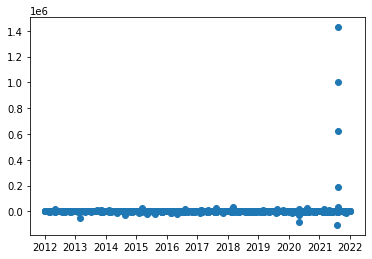

In [11]:
plt.scatter(pd.to_datetime(df["date"]), df["perc_change"])
plt.show()

Few outliers are present in the percentage difference between EPS and EPS estimated. Therefore, we will fitler out rows that are greater than 3 or less than -3 standard deviations away.

In [12]:
df = df[df.perc_change.between(df.perc_change.quantile(.01), df.perc_change.quantile(.99))]
print("Earnings Surprise Average: {}".format(df["perc_change"].mean()))

Earnings Surprise Average: 8.697451443710879


#### Distribution of Historical Earnings Surprises

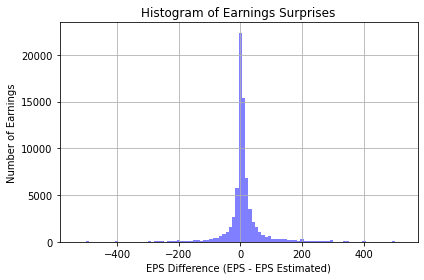

In [13]:
num_bins = 100
plt.hist(df["perc_change"], num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('EPS Difference (EPS - EPS Estimated)')
plt.ylabel('Number of Earnings')
plt.title('Histogram of Earnings Surprises')
plt.grid(True)
plt.tight_layout()
plt.savefig('visuals/histogram_eps_diff.png', facecolor='white', transparent=False)
plt.show()

After removing outliers, we can see that the majority of historical earnings follow a normal distribution around the mean of 9%.

#### Significant Earnings Surprise Breakdown

In [14]:
pos_surp_thres = 15
neg_surp_thres = -15

pos_surp = df[(df.perc_change > pos_surp_thres)]
neg_surp = df[(df.perc_change < neg_surp_thres)]
neu_surp = df[(df.perc_change < pos_surp_thres) & (df.perc_change > neg_surp_thres)]

x = ["Positive", "Neutral", "Negative"]
surprises = [len(pos_surp), len(neu_surp), len(neg_surp)]

print(len(pos_surp))
print("-------------")
print(len(neg_surp))
print("-------------")
print(len(neu_surp))

20858
-------------
10443
-------------
42644


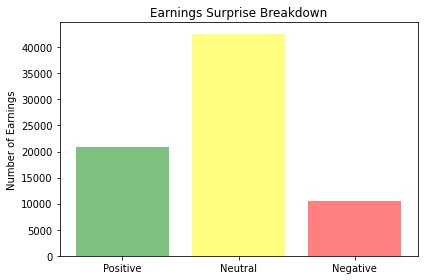

In [15]:
# Breakdown of the total number of each type of surprise in the dataset
# Positive: >15% surprise
# Neutral: <15% surprise and >-15% surprise
# Negative: <-15% surprise
plt.bar(x, surprises, color=['green', 'yellow', 'red'], alpha=0.5)
plt.ylabel('Number of Earnings')
plt.title('Earnings Surprise Breakdown')
plt.tight_layout()
plt.savefig('visuals/earn_bar.png', facecolor='white', transparent=False)
plt.show()

From the bar chart above, there are significantly more positive earnings surprises than negative earnings surprises. Therefore, it might be more lucrative, you only go long plays on earnings. 

#### Earnings Surprise Breakdown Based on Earnings Time

In [16]:
print(df["time"].unique())

['amc' 'bmo']


In [17]:
pos_bmo = df[(df.perc_change > pos_surp_thres) & (df["time"] == 'bmo')]
pos_amc = df[(df.perc_change > pos_surp_thres) & (df["time"] == 'amc')]
neu_bmo = df[(df.perc_change < pos_surp_thres) & (df.perc_change > neg_surp_thres) & (df["time"] == 'bmo')]
neu_amc = df[(df.perc_change < pos_surp_thres) & (df.perc_change > neg_surp_thres) & (df["time"] == 'amc')]
neg_bmo = df[(df.perc_change < neg_surp_thres) & (df["time"] == 'bmo')]
neg_amc = df[(df.perc_change < neg_surp_thres) & (df["time"] == 'amc')]

In [18]:
x = ["Positive", "Neutral", "Negative"]
surprises_bmo = [len(pos_bmo), len(neu_bmo), len(neg_bmo)]
surprises_amc = [len(pos_amc), len(neu_amc), len(neg_amc)]

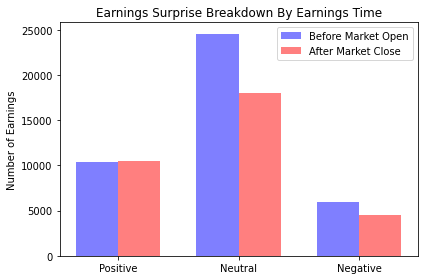

In [19]:
ind = np.arange(3) 
width = 0.35       
plt.bar(ind, surprises_bmo, width, label='Before Market Open', color='blue', alpha=0.5)
plt.bar(ind+width, surprises_amc, width,
    label='After Market Close', color='red', alpha=0.5)

plt.ylabel('Number of Earnings')
plt.title('Earnings Surprise Breakdown By Earnings Time')

plt.xticks(ind + width / 2, ('Positive', 'Neutral', 'Negative'))
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('visuals/earn_bar_time.png', facecolor='white', transparent=False)
plt.show()


There is no significant difference between earnings surprise and when the earnings is announced (before market open or after market close).

#### Earnings Surprise Breakdown by Day of Week

In [20]:
# Need to find the date information using earnings date column
dates = pd.to_datetime(df["date"])
df["dow"] = dates.dt.dayofweek
print(df["dow"])


0        0
1        0
2        0
3        0
4        1
        ..
75573    2
75574    3
75575    1
75576    2
75577    3
Name: dow, Length: 74067, dtype: int64


/var/folders/fp/ky7t_b41243bb9937z642tf00000gn/T/ipykernel_91819/4232186198.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["dow"] = dates.dt.dayofweek


In [21]:
pos_m = df[(df.perc_change > pos_surp_thres) & (df["dow"] == 0)]
pos_tu = df[(df.perc_change > pos_surp_thres) & (df["dow"] == 1)]
pos_w = df[(df.perc_change > pos_surp_thres) & (df["dow"] == 2)]
pos_th = df[(df.perc_change > pos_surp_thres) & (df["dow"] == 3)]
pos_f = df[(df.perc_change > pos_surp_thres) & (df["dow"] == 4)]

neu_m = df[(df.perc_change < pos_surp_thres) & (df.perc_change > neg_surp_thres) & (df["dow"] == 0)]
neu_tu = df[(df.perc_change < pos_surp_thres) & (df.perc_change > neg_surp_thres) & (df["dow"] == 1)]
neu_w = df[(df.perc_change < pos_surp_thres) & (df.perc_change > neg_surp_thres) & (df["dow"] == 2)]
neu_th = df[(df.perc_change < pos_surp_thres) & (df.perc_change > neg_surp_thres) & (df["dow"] == 3)]
neu_f = df[(df.perc_change < pos_surp_thres) & (df.perc_change > neg_surp_thres) & (df["dow"] == 4)]

neg_m = df[(df.perc_change < neg_surp_thres) & (df["dow"] == 0)]
neg_tu = df[(df.perc_change < neg_surp_thres) & (df["dow"] == 1)]
neg_w = df[(df.perc_change < neg_surp_thres) & (df["dow"] == 2)]
neg_th = df[(df.perc_change < neg_surp_thres) & (df["dow"] == 3)]
neg_f = df[(df.perc_change < neg_surp_thres) & (df["dow"] == 4)]

In [22]:
x = ["Positive", "Neutral", "Negative"]
surprises_m = [len(pos_m), len(neu_m), len(neg_m)]
surprises_tu = [len(pos_tu), len(neu_tu), len(neg_tu)]
surprises_w = [len(pos_w), len(neu_w), len(neg_w)]
surprises_th = [len(pos_th), len(neu_th), len(neg_th)]
surprises_f = [len(pos_f), len(neu_f), len(neg_f)]

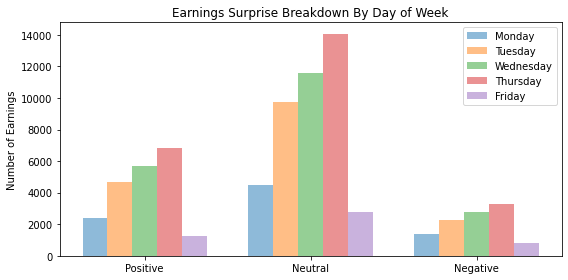

In [23]:
ind = np.arange(3) 
width = 0.15
plt.figure(figsize=(8, 4))
plt.bar(ind, surprises_m, width, label='Monday', alpha=0.5)
plt.bar(ind+width, surprises_tu, width, label='Tuesday', alpha=0.5)
plt.bar(ind+(2*width), surprises_w, width, label='Wednesday', alpha=0.5)
plt.bar(ind+(3*width), surprises_th, width, label='Thursday', alpha=0.5)
plt.bar(ind+(4*width), surprises_f, width, label='Friday', alpha=0.5)

plt.ylabel('Number of Earnings')
plt.title('Earnings Surprise Breakdown By Day of Week')

plt.xticks(ind + width*2, ('Positive', 'Neutral', 'Negative'))

plt.legend(loc='best')
plt.tight_layout()
plt.savefig('visuals/earn_bar_dow.png', facecolor='white', transparent=False)
plt.show()

### Feature Engineering

#### Create lagging features

Added lagging features derived from earnings data within the SQL statement. We already have lagging features for pricing data with the technical indicators. Now we can hide symbol as feature from the model.

In [24]:
# Null values within one lag
numer = df["lastEps"].isnull().sum()
denom = len(df["perc_change"])

null_perc = numer/denom * 100
print(null_perc)
print(numer)
print(denom)

3.363171182847962
2491
74067


In [25]:
# Null values within two lags
numer = df["last2Eps"].isnull().sum()
denom = len(df["perc_change"])

null_perc = numer/denom * 100
print(null_perc)
print(numer)
print(denom)

6.680437981827264
4948
74067


In [26]:
# Drop symbol
df = df.drop(["symbol"], axis=1)
print(df)

                    id      date   eps  epsEstimated time        open  \
0      2012-01-09-WDFC    1/9/12  0.42          0.54  amc   40.290001   
1      2012-01-09-SCHN    1/9/12  0.25          0.23  bmo   42.770000   
2       2012-01-09-HWM    1/9/12 -0.09         -0.09  bmo   20.824589   
3       2012-01-09-AYI    1/9/12  0.74          0.67  bmo   54.980000   
4       2012-01-10-SNX   1/10/12  1.37          1.14  amc   15.895000   
...                ...       ...   ...           ...  ...         ...   
75573   2021-12-22-KMX  12/22/21  1.63          1.44  bmo  139.700000   
75574  2021-12-23-VAXX  12/23/21 -0.44         -0.12  bmo    6.580000   
75575  2021-12-28-CALM  12/28/21  0.02          0.28  bmo   37.000000   
75576  2021-12-29-FCEL  12/29/21 -0.07         -0.02  bmo    5.130000   
75577  2021-12-30-CRON  12/30/21 -0.04         -0.09  bmo    3.795000   

             high         low       close    adjClose  ...   wma_10   wma_20  \
0       41.560001   39.840000   41.080002  

#### Create date features

In [27]:
df["month"] = pd.DatetimeIndex(df["date"]).month
print(df["month"])

0         1
1         1
2         1
3         1
4         1
         ..
75573    12
75574    12
75575    12
75576    12
75577    12
Name: month, Length: 74067, dtype: int64


In [28]:
df["day"] = pd.DatetimeIndex(df["date"]).day
print(df["day"])

0         9
1         9
2         9
3         9
4        10
         ..
75573    22
75574    23
75575    28
75576    29
75577    30
Name: day, Length: 74067, dtype: int64


In [29]:
df["year"] = pd.DatetimeIndex(df["date"]).year
print(df["year"])

0        2012
1        2012
2        2012
3        2012
4        2012
         ... 
75573    2021
75574    2021
75575    2021
75576    2021
75577    2021
Name: year, Length: 74067, dtype: int64


In [30]:
# Drop date
df = df.drop(["date"], axis=1)
print(df)

                    id   eps  epsEstimated time        open        high  \
0      2012-01-09-WDFC  0.42          0.54  amc   40.290001   41.560001   
1      2012-01-09-SCHN  0.25          0.23  bmo   42.770000   44.990002   
2       2012-01-09-HWM -0.09         -0.09  bmo   20.824589   21.319340   
3       2012-01-09-AYI  0.74          0.67  bmo   54.980000   57.810001   
4       2012-01-10-SNX  1.37          1.14  amc   15.895000   16.055000   
...                ...   ...           ...  ...         ...         ...   
75573   2021-12-22-KMX  1.63          1.44  bmo  139.700000  139.800000   
75574  2021-12-23-VAXX -0.44         -0.12  bmo    6.580000    6.680000   
75575  2021-12-28-CALM  0.02          0.28  bmo   37.000000   38.410000   
75576  2021-12-29-FCEL -0.07         -0.02  bmo    5.130000    5.300000   
75577  2021-12-30-CRON -0.04         -0.09  bmo    3.795000    4.180000   

              low       close    adjClose    volume  ...   lastSurp  \
0       39.840000   41.08000

#### Encode time variable

In [31]:
df["time"].loc[(df['time'] == "bmo")] = 0
df["time"].loc[(df['time'] == "amc")] = 1
df["time"] = df["time"].astype(int)

/Users/brodyuehara/Documents/GitHub/predicting-earnings-surprises/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [32]:
df = df.dropna()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69119 entries, 1522 to 75577
Data columns (total 38 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                69119 non-null  object 
 1   eps               69119 non-null  float64
 2   epsEstimated      69119 non-null  float64
 3   time              69119 non-null  int64  
 4   open              69119 non-null  float64
 5   high              69119 non-null  float64
 6   low               69119 non-null  float64
 7   close             69119 non-null  float64
 8   adjClose          69119 non-null  float64
 9   volume            69119 non-null  int64  
 10  unadjustedVolume  69119 non-null  int64  
 11  change            69119 non-null  float64
 12  changePercent     69119 non-null  float64
 13  vwap              69119 non-null  float64
 14  changeOverTime    69119 non-null  float64
 15  sma_5             69119 non-null  float64
 16  sma_10            69119 non-null  flo

In [33]:
# Drop id and percentage change
# Removing percentage change because it wont be known at time of prediction
df = df.drop(["id", "perc_change"], axis=1)
print(df)

        eps  epsEstimated  time        open    high      low   close  \
1522   0.38          0.37     0   19.790001   19.83   19.500   19.68   
2334   0.07          0.02     1    1.540000    1.73    1.540    1.64   
2653  -0.05         -0.07     0    1.460000    1.48    1.410    1.45   
2716  -0.02         -0.03     1    1.560000    1.59    1.550    1.58   
2977   0.62          0.54     1   28.790001   29.24   28.650   28.73   
...     ...           ...   ...         ...     ...      ...     ...   
75572  0.91          0.80     0  129.830000  135.46  127.000  133.41   
75573  1.63          1.44     0  139.700000  139.80  127.520  127.87   
75575  0.02          0.28     0   37.000000   38.41   36.790   38.30   
75576 -0.07         -0.02     0    5.130000    5.30    4.830    5.11   
75577 -0.04         -0.09     0    3.795000    4.18    3.792    4.01   

         adjClose    volume  unadjustedVolume  ...    lastSurp   last2Surp  \
1522    12.347655    299500            299500  ...    0.0

### Split Dataset

In [34]:
# Split Dataset
X = df.iloc[:, 1:]
y = df.iloc[:, :1]

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [36]:
print(X_test)

       epsEstimated  time        open        high         low       close  \
23522          7.31     1  360.549988  364.089996  359.000000  361.010010   
62000          0.19     0   32.549999   33.450001   32.040001   32.119999   
40292         -0.69     1    6.000000    7.890000    5.880000    7.230000   
55084          0.30     0   19.760000   20.240000   17.500000   18.020000   
16382          0.35     1   40.504131   40.561981   39.190083   39.421490   
...             ...   ...         ...         ...         ...         ...   
74085         -0.89     1   98.040000   98.135000   93.500000   95.630000   
30536          0.20     1   24.730000   24.900000   24.309999   24.719999   
5067           0.25     0   23.660000   24.130000   23.100000   23.750000   
64580          0.12     1    8.650000    8.660000    8.090000    8.120000   
25015          0.04     0    9.200000    9.330000    9.070000    9.200000   

         adjClose   volume  unadjustedVolume   change  ...   lastSurp  \
23

### Fit Data to Random Forest Model

In [37]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(X_train, y_train)

/var/folders/fp/ky7t_b41243bb9937z642tf00000gn/T/ipykernel_91819/572084302.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X_train, y_train)


RandomForestRegressor(n_estimators=10, random_state=0)

In [38]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': regressor.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
print(importances)

           Attribute  Importance
0       epsEstimated    0.755306
27           lastEps    0.087682
30          last2Est    0.057502
28          last2Eps    0.020112
29           lastEst    0.015710
25          lastSurp    0.010224
9             change    0.007424
33               day    0.007022
26         last2Surp    0.006552
7             volume    0.005056
21            rsi_14    0.004003
19      volatility_5    0.003515
20     volatility_10    0.003033
12    changeOverTime    0.002066
16             ema_5    0.001770
18            ema_20    0.001738
8   unadjustedVolume    0.001613
31               dow    0.001277
3               high    0.001075
10     changePercent    0.001018
32             month    0.001014
34              year    0.000768
2               open    0.000718
15            sma_20    0.000493
6           adjClose    0.000459
5              close    0.000398
24            wma_20    0.000391
4                low    0.000335
22             wma_5    0.000320
23        

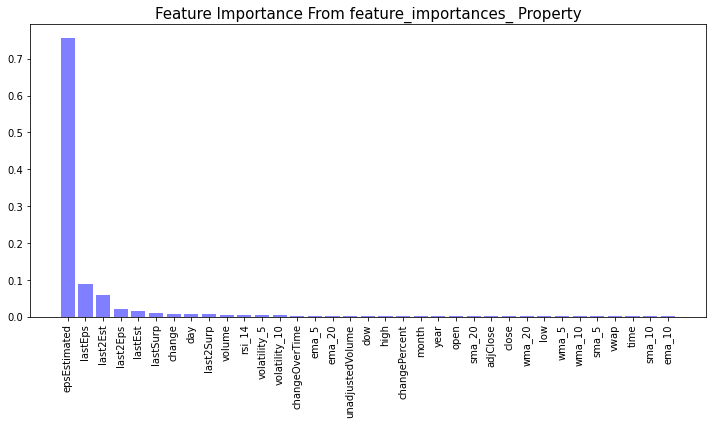

In [39]:
plt.figure(figsize=(10,6))
plt.bar(x=importances['Attribute'], height=importances['Importance'], facecolor='blue', alpha=0.5)
plt.title('Feature Importance From feature_importances_ Property', size=15)
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.savefig('visuals/feature_import.png', facecolor='white', transparent=False)
plt.show()

In [40]:
# Besides first (epsEstimated)
importances = importances.iloc[1: , :]

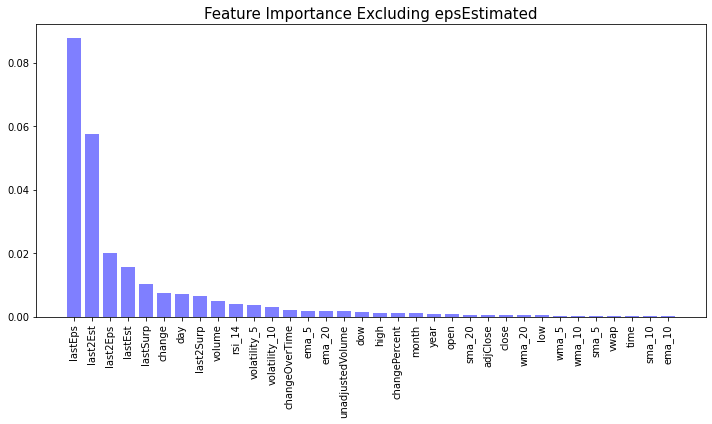

In [41]:
plt.figure(figsize=(10,6))
plt.bar(x=importances['Attribute'], height=importances['Importance'], facecolor='blue', alpha=0.5)
plt.title('Feature Importance Excluding epsEstimated', size=15)
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.savefig('visuals/feature_import_exlud.png', facecolor='white', transparent=False)
plt.show()

### Predict Labeled Testing Data

In [42]:
y_pred = regressor.predict(X_test)
output = y_test
print(len(y_pred))

13824


In [43]:
output["estimate"] = y_pred
output["error"] = abs(output["estimate"] - output["eps"])
print(output)

        eps  estimate  error
23522  8.74     7.327  1.413
62000  0.28     0.182  0.098
40292 -0.92    -0.745  0.175
55084  0.34     0.327  0.013
16382  0.74     0.462  0.278
...     ...       ...    ...
74085 -0.97    -0.976  0.006
30536  0.20     0.216  0.016
5067   0.26     0.222  0.038
64580  0.15     0.146  0.004
25015  0.05     0.076  0.026

[13824 rows x 3 columns]


### Mean Absolute Error

In [44]:
# Calculate mean absolute percentage error (MAPE)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true = output["eps"], y_pred = output["estimate"])
print("Mean Absolute Error: {}".format(mae))

Mean Absolute Error: 0.16445638695962098


### Root Mean Squared Error

In [45]:
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(y_true = output["eps"], y_pred = output["estimate"], squared=False)
print("Root Mean Squared Error: {}".format(rms))

Root Mean Squared Error: 0.7819686747274898


### R2 Score

In [46]:
from sklearn.metrics import r2_score
r2 = r2_score(y_true = output["eps"], y_pred = output["estimate"])
print("R2 Score: {}".format(r2))

R2 Score: 0.8226971670279154


## Classifying into Surprise Categories

In [47]:
# Earnings Surprise Group 1 (Control)
surp_cont = (y_test["eps"] - X_test["epsEstimated"]) / abs(X_test["epsEstimated"]) * 100
# Earnings Surprise Group 2 (Variable)
surp_var = (y_test["estimate"] - X_test["epsEstimated"]) / abs(X_test["epsEstimated"]) * 100
print("Predicted Change:")
print(surp_var)
print("---"*10)
print("Acutal Change:")
print(surp_cont)

Predicted Change:
23522     0.232558
62000    -4.210526
40292    -7.971014
55084     9.000000
16382    32.000000
           ...    
74085    -9.662921
30536     8.000000
5067    -11.200000
64580    21.666667
25015    90.000000
Length: 13824, dtype: float64
------------------------------
Acutal Change:
23522     19.562244
62000     47.368421
40292    -33.333333
55084     13.333333
16382    111.428571
            ...    
74085     -8.988764
30536      0.000000
5067       4.000000
64580     25.000000
25015     25.000000
Length: 13824, dtype: float64


In [48]:
pos_surp_2 = len(surp_var[(surp_var > pos_surp_thres)])
neg_surp_2 = len(surp_var[(surp_var < neg_surp_thres)])
neu_surp_2 = len(surp_var[(surp_var < pos_surp_thres) & (surp_var > neg_surp_thres)])

In [49]:
pos_surp_1 = len(surp_cont[(surp_cont > pos_surp_thres)])
neg_surp_1 = len(surp_cont[(surp_cont < neg_surp_thres)])
neu_surp_1 = len(surp_cont[(surp_cont < pos_surp_thres) & (surp_cont > neg_surp_thres)])

In [50]:
print("Acutal Surprise Breakdown - Positive: {}, Neutral: {}, Negative: {}".format(pos_surp_1, neu_surp_1, neg_surp_1))

Acutal Surprise Breakdown - Positive: 3991, Neutral: 7977, Negative: 1836


In [51]:
print("Predicted Surprise Breakdown - Positive: {}, Neutral: {}, Negative: {}".format(pos_surp_2, neu_surp_2, neg_surp_2))

Predicted Surprise Breakdown - Positive: 3605, Neutral: 8837, Negative: 1377


## Choose From Options Below:

### Export Model to S3

In [52]:
import boto3
import pickle
from decouple import config
#access_key_id =  config("iam_access_key")
#secret_access_key = config("iam_secret_key")

#session = boto3.Session(
#    aws_access_key_id=access_key_id,
#    aws_secret_access_key=secret_access_key,)

#s3_resource = session.resource('s3')

ModuleNotFoundError: No module named 'boto3'

In [ ]:
#bucket='rfmodelpkl'
#key= 'earnings_surprise_random_forest.pkl'

#pickle_byte_obj = pickle.dumps(regressor)

#s3_resource.Object(bucket,key).put(Body=pickle_byte_obj)

### Export Model as PKL file

In [ ]:
#import joblib
#joblib.dump(regressor, 'models/earnings_surprise_random_forest.pkl')

In [ ]:
# Zipping model file for the lambda layers
#import zipfile
#zipfile.ZipFile('model.zip', mode='w').write("models/earnings_surprise_random_forest.pkl")